## File type demo

This notebook demonstrates some of the capabilities of the eegyolk library in terms of reading the cnt file type. It also demonstrates the importance of the dataformat argument in the mne library. Previous work had let some arguments in reading cnt files default to preset values.
This notebook specifically demonstrates how whether the format of int32 or int16 influences the understanding of the file

#### Imports

In [25]:
import mne      # toolbox for analyzing and visualizing EEG data
import os       # using operating system dependent functionality (folders)
import pandas   # data analysis and manipulation
import numpy    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import glob
import numpy as np
import pandas as pd
from numpy.fft import fft, fftfreq
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt

from mne.time_frequency.tfr import morlet
from mne.viz import plot_filter, plot_ideal_filter


from IPython.display import clear_output
import warnings

import sys

Below eegyolk is importted in it's most updated version
But the cell could be replaced by importing the stable library and then importing the modules of it.

In [2]:

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
#import initialization_functions #library to import data
import epod_helper
import raw
from config import Config
from raw import RawData

#### Load EEG files
Change your config file to change where data is coming from

In [3]:
!pwd

/home/cmoore/eegyolk/demos


In [4]:
config = Config()


In [5]:
!ls -lah ./.config.json

ls: cannot access './.config.json': No such file or directory


In [6]:
eeg_file_root = "../../volume-ceph/ePodium_projectfolder"
acquired = RawData(config.get_directory('data'), config.get_directory('metadata'))

Note we assume you are looking at bdf files

In [16]:
acquired.raw.head()

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,35,/volume-ceph/DDP_projectfolder/11mnd mmn/035_1...,035_11_jc_mmn36_slp_mmn25_slp,11,331.0,11.033333,0.919444
1,27,/volume-ceph/DDP_projectfolder/11mnd mmn/027_1...,027_11_jc_mmn25_wk,11,326.0,10.866667,0.905556
2,25,/volume-ceph/DDP_projectfolder/11mnd mmn/025_1...,025_11_mc_mmn36_wk,11,360.0,12.000000,1.000000
3,35,/volume-ceph/DDP_projectfolder/11mnd mmn/035_1...,035_11_jc_mmn36slp_mmn25_slp_2,11,331.0,11.033333,0.919444
4,30,/volume-ceph/DDP_projectfolder/11mnd mmn/030_1...,030_11_jc_mmn36_wk_mmn25_wk,11,328.0,10.933333,0.911111


In [20]:
data_raw = acquired.as_mne[4]

In [21]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 030_11_jc_mmn36_wk_mmn25_wk.cnt, 64 x 184050 (368.1 s), ~89.9 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 184050)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2002-06-17 13:51:34 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


# Now we will show as a pandas dataframe

In [22]:
raw_df = data_raw.to_data_frame()
raw_df.head()

,time,O2,O1,OZ,PZ,P4,CP4,P8,C4,TP8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,0,-2.424773e+06,-5.162782e+06,-2.626446e+05,1.568894e+06,-1.682337e+06,-3.808384e+06,-1.358133e+07,8.041344e+06,-6.727782e+06,...,-6.621729e+06,-3.377405e+06,-2.848217e+06,3.779089e+06,-4.552465e+06,3.568933e+06,1.269723e+06,-4.302350e+06,2.120955e+06,-1.178174e+06
1,2,-1.704209e+06,-4.418695e+06,-5.712613e+04,1.259687e+06,-2.334547e+06,-3.160406e+06,-1.283886e+07,7.036182e+06,-6.202408e+06,...,-6.462989e+06,-3.434069e+06,-2.654544e+06,3.356647e+06,-4.575157e+06,3.010211e+06,1.155352e+06,-4.874470e+06,1.778881e+06,-1.687964e+06
2,4,-1.795708e+06,-4.441592e+06,-5.712613e+04,1.477281e+06,-1.865411e+06,-3.149036e+06,-1.302162e+07,7.732947e+06,-6.122395e+06,...,-6.780472e+06,-3.910080e+06,-2.962152e+06,5.411779e+06,-5.006583e+06,3.511918e+06,9.952250e+05,-4.828702e+06,1.106131e+06,-1.914539e+06
3,6,-2.882272e+06,-5.529105e+06,-7.307660e+05,1.316936e+06,-1.693783e+06,-4.103954e+06,-1.408392e+07,8.109872e+06,-6.944767e+06,...,-7.971024e+06,-4.998115e+06,-4.112822e+06,5.594440e+06,-6.073806e+06,3.044399e+06,-5.702932e+04,-5.423717e+06,-1.025519e+05,-2.537627e+06
4,8,-4.128963e+06,-6.834120e+06,-1.804022e+06,6.755864e+05,-2.254470e+06,-5.286233e+06,-1.526044e+07,7.652960e+06,-8.098426e+06,...,-8.764725e+06,-5.508136e+06,-4.955883e+06,4.646781e+06,-6.618775e+06,2.428652e+06,-6.289107e+05,-6.064497e+06,-5.358589e+05,-2.888823e+06


Now we used the default settings above, let's just switch the settings and compare

In [26]:

class SwitchedRawData:

    age_groups = {
        11: '11mnd mmn',
        17: '17mnd mmn',
        23: '23mnd mmn',
        29: '29mnd mmn',
        35: '35mnd mmn',
        41: '41mnd mmn',
        47: '47mnd mmn',
    }

    age_files = {
        11: 'ages_11mnths.txt',
        17: 'ages_17mnths.txt',
        23: 'ages_23mnths.txt',
        29: 'ages_29mnths.txt',
        35: 'ages_35mnths.txt',
        41: 'ages_41mnths.txt',
        47: 'ages_47mnths.txt',
    }

    cnt_read_args = {
        'eog': 'auto',
        # NOTE(wvxvw): This is a way of preventing another waring hen
        # parsing CNT files.  The default value is `auto', but MNE
        # cannot identify how many bytes per event are used, and gives
        # a warning about that.  There seem to be only two possible
        # options: `int16' and `int32'.  `int32' was chosen by the old
        # code by default, so the new code keeps the same behavior
        # while making it more explicit (and avoiding the warning).
        'data_format': 'int16',
        # NOTE(wvxvw): Note that the default is the US format, and all
        # dates are botched because of that.  Also note that
        # "conveniently", the dates are in the worst imaginable
        # format:
        # https://commons.apache.org/proper/commons-lang/apidocs/org/\
        # apache/commons/lang3/time/FastDateFormat.html That is
        # 3-digit year, that Python doesn't support...  The format
        # should really be `dd/mm/yyy', but that is not supported by
        # the MNE library.
        'date_format': 'dd/mm/yy',
        'verbose': False,
    }

    def __init__(self, raw_data_dir, meta_dir):
        self.cnt_files = pd.concat(self.read_all_age_groups(raw_data_dir))
        self.ages = pd.concat(self.read_ages_meta(meta_dir))
        self.raw = pd.merge(
            self.cnt_files,
            self.ages,
            how='left',
            on=('age_group', 'code'),
        )

    def read_cnt(self, fname, preload=True):
        return mne.io.read_raw_cnt(
            fname,
            preload=preload,
            **self.cnt_read_args
        )

    def read_good_cnt(self, fname, preload=True):
        return mne.io.read_raw_cnt(
            fname,
            preload=preload,
            **self.cnt_read_args
        )

    def read_age_group(self, raw_data_dir, age_group, directory):
        pattern = os.path.join(raw_data_dir, directory, '*.cnt')
        logging.info('Acquiring: %s', pattern)
        cnts = glob(pattern)
        names = tuple(
            os.path.splitext(os.path.basename(f))[0]
            for f in cnts
        )
        codes = tuple(
            int(re.search(r'\d+', x).group())
            for x in names
        )
        return pd.DataFrame(
            list(zip(codes, cnts, names)),
            columns=('code', 'cnt_path', 'cnt_file'),
        )

    def read_all_age_groups(self, raw_data_dir):
        for age_group, directory in self.age_groups.items():
            ag_df = self.read_age_group(raw_data_dir, age_group, directory)
            ag_df['age_group'] = age_group
            yield ag_df

    def read_ages_meta(self, meta_dir):
        for age_group, age_file in self.age_files.items():
            df = pd.read_csv(
                os.path.join(meta_dir, 'ages', age_file),
                sep="\t"
                )
            df['age_group'] = age_group
            yield df

    def breakdown_by_age(self):
        return [
            self.raw.loc[self.raw['age_group'] == ag]
            for ag in self.age_groups.keys()
        ]

    def unlabeled(self):
        return self.raw.loc[self.raw['age_days'].isnull()]

    def fill_unlabeled(self):
        '''Fill in the missing age data based on the age group the
        subject is in

        We know the age group (i.e. 11, 17, 23, ... months etc) of all
        the subjects, based on the folder the files are in and based
        on the file name. We have got the exact ages (in days) of most
        subjects seperately, which we have added to the DataFrame
        above. For some of the subjects, we don't have the exact age
        and therefore we set this equal to the age group.
        '''
        self.raw['age_months'].fillna(self.raw['age_group'], inplace=True)
        self.raw['age_days'].fillna(self.raw['age_group'] * 30, inplace=True)
        self.raw['age_years'].fillna(self.raw['age_group'] / 12, inplace=True)

    @property
    def as_mne(self):
        return MneViewer(self)

    def filter_broken(self):
        '''This did not exist in the original code, but it makes it
        easier to deal with MNE file reading errors: we just try
        reading all the files once, and sort them into two groups:
        raw_good and raw_bad.
        '''
        can_read = self.raw.index.to_series()
        for i, row in self.raw.iterrows():
            try:
                # Usually, when MNE fails to read a file, there will
                # also be a warning, as we will throw those away, we
                # don't care about those warnings.
                with warnings.catch_warnings():
                    with mne.utils.use_log_level('error'):
                        self.read_cnt(row['cnt_path'], preload=False)
                can_read[i] = 1
            except Exception as e:
                # This is a problem with MNE library: it simply fails
                # to read some files, but instead of giving a
                # meaningful error, it breaks with all kinds of
                # generic errors.  Luckily, there seem to be
                # relatively few of these files.
                can_read[i] = 0

        can_read = np.array(can_read)
        self.raw_good = self.raw[can_read == 1]
        self.raw_bad = self.raw[can_read == 0]

    def count_events(self):
        tmin = -0.2
        tmax = 0.8
        # means from the first instant to t = 0
        baseline = None, 0
        counts = pd.Series(dtype=np.int32)
        mappings = {}

        for i, path in enumerate(self.raw_good['cnt_path']):
            raw = self.read_cnt(path)

            # events is going to have event ids in the last column
            events, mapping = mne.events_from_annotations(raw, verbose=False)
            uniques = np.unique(events[:, 2], return_counts=True)
            single_counts = dict(zip(*uniques))
            counts = counts.add(pd.Series(single_counts), fill_value=0)
            # The original code used this mapping, but this mapping
            # gives different keys for the same values for each
            # mne.events_from_annotations() result... so, it seems
            # like the original code was simply confused about what it
            # was showing.
            #
            # mapping = {v: int(k) for k, v in mapping.items()}
            # mappings.update(mapping)



In [28]:
import logging
acquired = SwitchedRawData(config.get_directory('data'), config.get_directory('metadata'))

TypeError: 'module' object is not callable

In [7]:
eeg_list = []
eeg_filenames = []
eeg_filelocation = []



pattern = os.path.join(eeg_file_root, '**/*.bdf')

files = glob.glob(pattern, recursive=True)

for file in files:
    if file.endswith('.bdf'):  # and len(file) == 8:
        BdfFile = mne.io.read_raw_bdf(file)
        eeg_list.append(BdfFile)
        eeg_filenames.append(file.replace(".bdf", ""))
        eeg_filelocation.append(file)
        clear_output(wait=True)
print(len(eeg_list), "EEG files loaded")

248 EEG files loaded


In [8]:
# eeg_filelocation

In [9]:
# eeg_filenames

### Make a synthetic EEG like array

In [10]:


sfreq = 1000. # signal collection frequency?
f_p = 40. # this is the stop freuqency, above which we should 0
flim = (1., sfreq / 2.)  # limits for plotting

In [11]:
# make something to filter
dur = 10.
center = 2.
morlet_freq = f_p
tlim = [center - 0.2, center + 0.2]
tticks = [tlim[0], center, tlim[1]]
flim = [20, 70]

x = np.zeros(int(sfreq * dur) + 1)
blip = morlet(sfreq, [morlet_freq], n_cycles=7)[0].imag / 20.
n_onset = int(center * sfreq) - len(blip) // 2
x[n_onset:n_onset + len(blip)] += blip
x_orig = x.copy()

rng = np.random.RandomState(0)
x += rng.randn(len(x)) / 1000.
x += np.sin(2. * np.pi * 60. * np.arange(len(x)) / sfreq) / 2000.

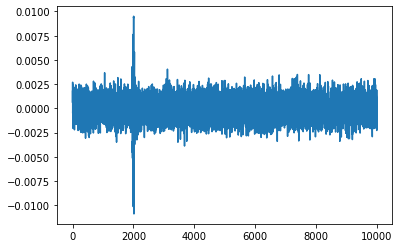

In [12]:
plt.plot(x)

## Download sample data from MNE library
The below is cell is commented out as it may be skipped if you have the data

In [13]:
# sample_data_folder = mne.datasets.sample.data_path()
# sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
#                                     'sample_audvis_raw.fif')
# raw = mne.io.read_raw_fif(sample_data_raw_file)
# # use just 60 seconds of data and mag channels, to save memory
# raw.crop(0, 60).pick_types(meg='mag', stim=True).load_data()

Let's see what filtering looks like visually if we pull out low frequencies

In [14]:
with mne.viz._figure.use_browser_backend('matplotlib'):
        fig = raw.plot(duration=60, proj=False,
                                n_channels=len(raw.ch_names), remove_dc=False)

Using matplotlib as 2D backend.


AttributeError: module 'raw' has no attribute 'plot'

In [ ]:
#for cutoff in (0.1, 0.2):
cutoff = 0.2
raw_highpass = raw.copy().filter(l_freq=cutoff, h_freq=None)
with mne.viz._figure.use_browser_backend('matplotlib'):
    fig = raw_highpass.plot(duration=60, proj=False,
                            n_channels=len(raw.ch_names), remove_dc=False)
fig.subplots_adjust(top=0.9)
fig.suptitle('High-pass filtered at {} Hz'.format(cutoff), size='xx-large',
             weight='bold')

In [ ]:
raw_simple_filtered = hf.band_pass_filter(raw, 0.2, 5)

In [ ]:
## we can check channel names
#raw_simple_filtered.ch_names

In [ ]:
## we can know more about the data 
#help(raw_simple_filtered)

In [ ]:
# but let's just check our filter on the lowpass end to see what frequency is there
raw_simple_filtered.info['lowpass']

In [ ]:
# vars(raw_simple_filtered)

In [ ]:
print(type(raw.info['lowpass']))

In [ ]:
## Need to rewrite data path

In [ ]:
sample_eeg = eeg_filelocation[3]

In [ ]:
sample_eeg

In [ ]:
type(sample_eeg)

In [ ]:
sample_eeg_read = mne.io.read_raw_bdf(sample_eeg, preload= True)

In [ ]:
sample_eeg_filtered = hf.band_pass_filter(sample_eeg_read, 0, 2.38540286e-05)